In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import imblearn

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import plot_importance
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import auc, precision_recall_curve

pd.set_option('display.max_columns', None)

Reading in prepared data

In [35]:
train_college_imp = pd.read_csv('../data/train_college_imp.csv')

test_college_imp = pd.read_csv('../data/test_college_imp.csv')

This cell creates a feature that captures whether or not the student graduated from a four year college and removes some features that may leak information during modelling.  

In [36]:
def drop_stuff(df, l):
    for i in l:
        df.drop(i, axis = 1, inplace = True)
    return df

In [37]:
#subsetting those that graduated from a 4yr college and those that did not in train set.  
imp_coll_4yr_train = train_college_imp[(train_college_imp.graduated_Y == 1) & (train_college_imp.ps_level == 1)]
imp_not_coll_train = train_college_imp[(train_college_imp.graduated_Y != 1) | (train_college_imp.ps_level != 1)]

#creating target column indicating 4yr college graduation status
imp_coll_4yr_train['target'] = 1
imp_not_coll_train['target'] = 0

#list of features to drop that will corrupt modelling
drop_list_2 = ['ps_level','wages_cont', 'graduated_Y','Unnamed: 0']

#dropping features
drop_stuff(imp_coll_4yr_train,drop_list_2)
drop_stuff(imp_not_coll_train,drop_list_2)

#rejoining features of training dataset
imp_training = pd.concat([imp_coll_4yr_train,imp_not_coll_train])

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

Same manipulations as above but to the test set.

In [38]:
#subsetting those that graduated from a 4yr college and those that did not in test set.  
imp_coll_4yr_test = test_college_imp[(test_college_imp.graduated_Y == 1)&(test_college_imp.ps_level == 1)]
imp_not_coll_test = test_college_imp[(test_college_imp.graduated_Y != 1)|(test_college_imp.ps_level != 1)]

#creating target column indicating 4yr college graduation status
imp_coll_4yr_test['target'] = 1
imp_not_coll_test['target'] = 0

#dropping features from test set that would corrupt modelling
drop_stuff(imp_coll_4yr_test, drop_list_2)
drop_stuff(imp_not_coll_test, drop_list_2)

#rejoining features of training dataset
imp_testing = pd.concat([imp_coll_4yr_test,imp_not_coll_test])

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

In [39]:
imp_training.describe()

literacy_home  risk_factors       math_b    reading_b  math_conf_b  \
count    7920.000000   7920.000000  7920.000000  7920.000000   7920.00000   
mean        2.308965      0.792298    53.124197    52.943163      0.10186   
std         0.800221      0.895988     9.316385     9.335767      0.86407   
min         0.000000      0.000000    19.380000    24.910000     -1.83100   
25%         2.000000      0.000000    47.027500    46.720000     -0.52450   
50%         2.000000      1.000000    53.480000    53.370000      0.05600   
75%         3.000000      1.000000    59.580000    59.410000      0.57100   
max         3.000000      5.000000    86.680000    78.760000      1.77200   

       verbal_confidence      writing       sports     by_xcurr     homework  \
count        7920.000000  7920.000000  7920.000000  7920.000000  7920.000000   
mean            0.088699     0.252607     1.138889     1.161237    10.432449   
std             0.841729     0.859645     1.215571     1.310930     7.215670   
min            -2.197000    -1.847000     0.000000     0.000000     0.000000   
25%            -0.453000    -0.221100     0.000000     0.000000     5.000000   
50%             0.086250     0.241000     1.000000     1.000000     9.000000   
75%             0.561025     0.812000     2.000000     2.000000    14.000000   
max             1.596000     1.951000     7.000000     8.000000    45.000000   

        hedonics_b  hours_working_b  edu_confidence       math_1  \
count  7920.000000      7920.000000     7920.000000  7920.000000   
mean      3.322727         1.023359        6.490657    52.503432   
std       2.136198         1.622962        1.363817     9.622204   
min       0.000000         0.000000        1.000000    22.640000   
25%       2.000000         0.000000        6.000000    45.830000   
50%       3.000000         0.000000        6.000000    52.710000   
75%       4.000000         2.000000        7.000000    59.600000   
max       8.000000         9.000000        9.000000    79.850000   

       math_status_1     f1_xcurr  hours_working_1   hedonics_1  math_conf_1  \
count    7920.000000  7920.000000      7920.000000  7920.000000  7920.000000   
mean        5.309596     2.408965         2.824747     2.910354     0.051546   
std         0.993149     1.837933         2.398403     1.796306     0.904738   
min         1.000000     0.000000         0.000000     0.000000    -2.039000   
25%         5.000000     1.000000         0.000000     2.000000    -0.510000   
50%         6.000000     2.000000         3.000000     3.000000    -0.001000   
75%         6.000000     4.000000         4.000000     4.000000     0.528000   
max         6.000000     9.000000         9.000000     8.000000     1.811000   

        hs_ac_load       hs_gpa       effort      testing   v_facility  \
count  7920.000000  7920.000000  7920.000000  7920.000000  7920.000000   
mean     25.536490     4.379545   267.977083   158.570792   179.025500   
std       3.900347     1.297373   186.750717    25.952349    55.243745   
min       6.000000     0.000000     0.000000    74.850000    26.140000   
25%      24.000000     4.000000   125.000000   140.887500   145.710000   
50%      26.000000     5.000000   234.000000   159.675000   181.440000   
75%      28.000000     5.000000   357.000000   177.092500   219.400000   
max      34.000000     6.000000  1360.000000   231.160000   315.040000   

        m_facility   academic_p  iq_by_concientiousness  delinquency  \
count  7920.000000  7920.000000             7920.000000  7920.000000   
mean    284.101014  1242.480051            17108.687090     4.948207   
std      86.359244  1000.611370             6148.331021     6.406055   
min      26.530000     0.000000              917.600000     0.000000   
25%     226.587500   482.250000            12928.677500     0.000000   
50%     293.050000  1020.000000            16698.600000     3.600000   
75%     352.800000  1697.750000            20623.770000     7.000000   
max     479.100

with the addition of the 'target', a last bit of exploratory visualization

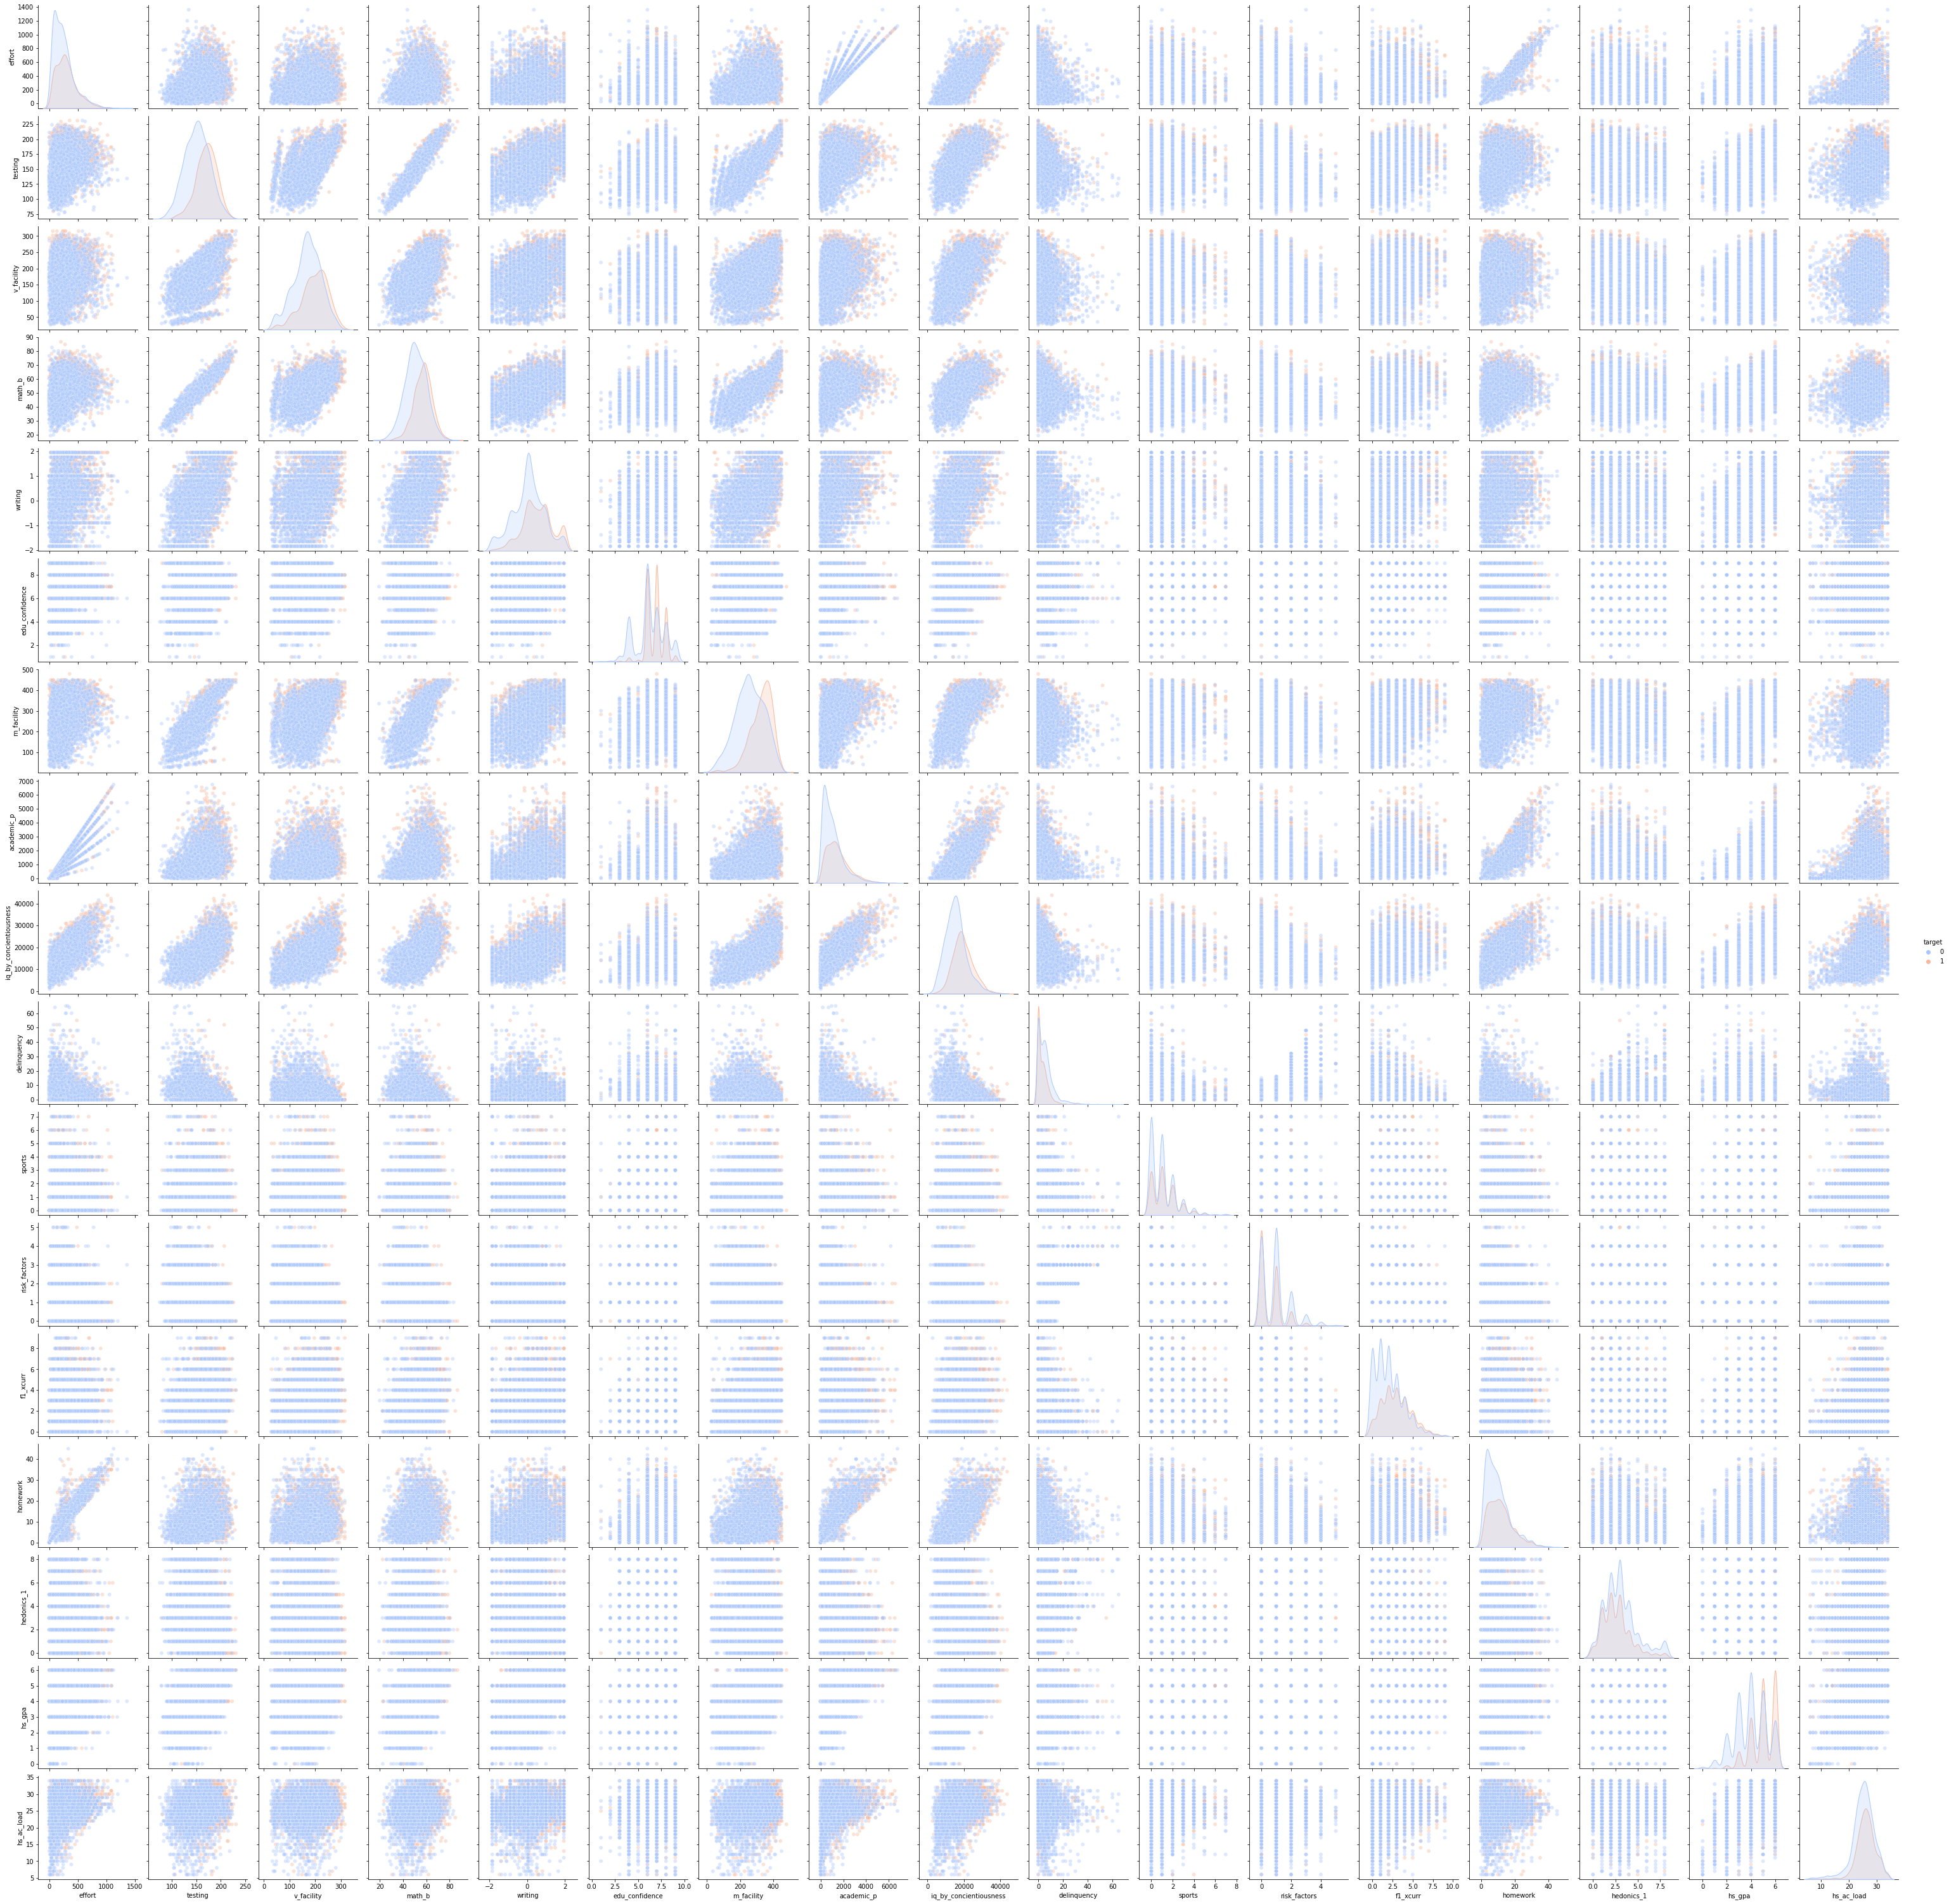

In [858]:
imp_features = imp_training[[ 'target','effort', 'testing', 'v_facility','math_b','writing','edu_confidence',
       'm_facility', 'academic_p', 'iq_by_concientiousness', 'delinquency','sports','risk_factors','f1_xcurr','homework',
                'hedonics_1','hs_gpa','hs_ac_load',]]

sns.pairplot(imp_features, hue = 'target', diag_kind = 'kde', palette= 'coolwarm', plot_kws=dict(alpha = 0.4),
                   diag_kws=dict(shade=True))

Separating target and features in training set.

In [10]:
imp_training_y = imp_training.target
imp_training_x = imp_training.drop(columns = 'target', axis = 1)

Separating target and features in test set

In [11]:
imp_testing_y = imp_testing.target
imp_testing_x = imp_testing.drop(columns = 'target', axis = 1)

Looking at class imbalance. Class imbalance is not severe enough to warrant upsampling.

In [12]:
print(f'decimal fraction of positive and negative target for training set: \n{imp_training.target.value_counts(normalize = True)}')
print(f'decimal fraction of positive and negative target for testing set: \n{imp_testing.target.value_counts(normalize = True)}')


decimal fraction of positive and negative target for training set: 
0    0.612879
1    0.387121
Name: target, dtype: float64
decimal fraction of positive and negative target for testing set: 
0    0.601212
1    0.398788
Name: target, dtype: float64


Creating a series of training and testing sets with 15, 20 and 25 best features, as well as a sets with minimal features, but that will be easy to interpret.

### kbest 15 features

In [13]:
selector = SelectKBest(f_classif, k=15) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb15 = imp_training_x[selected_columns]
X_test_kb15 = imp_testing_x[selected_columns]
print(X_train_kb15.shape, X_test_kb15.shape)

(7920, 15) (1981, 15)


In [14]:
X_test_kb15.columns

Index(['risk_factors', 'math_b', 'reading_b', 'writing', 'edu_confidence',
       'math_1', 'math_status_1', 'f1_xcurr', 'hs_gpa', 'testing',
       'v_facility', 'm_facility', 'academic_p', 'iq_by_concientiousness',
       'delinquency'],
      dtype='object')

kbest 15 provides a pretty lean set that, not surprisingly,  seems to prioritize academic ability.

### k best 20 features

In [15]:
selector = SelectKBest(f_classif, k=20) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb20 = imp_training_x[selected_columns]
X_test_kb20 = imp_testing_x[selected_columns]
print(X_train_kb20.shape, X_test_kb20.shape)

(7920, 20) (1981, 20)


In [16]:
X_train_kb20.columns

Index(['risk_factors', 'math_b', 'reading_b', 'math_conf_b', 'writing',
       'by_xcurr', 'hedonics_b', 'edu_confidence', 'math_1', 'math_status_1',
       'f1_xcurr', 'math_conf_1', 'hs_gpa', 'effort', 'testing', 'v_facility',
       'm_facility', 'academic_p', 'iq_by_concientiousness', 'delinquency'],
      dtype='object')

### k best 25 features

In [17]:
selector = SelectKBest(f_classif, k=25) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb25 = imp_training_x[selected_columns]
X_test_kb25 = imp_testing_x[selected_columns]
print(X_train_kb25.shape, X_test_kb25.shape)

(7920, 25) (1981, 25)


In [18]:
X_train_kb25.columns

Index(['literacy_home', 'risk_factors', 'math_b', 'reading_b', 'math_conf_b',
       'verbal_confidence', 'writing', 'by_xcurr', 'homework', 'hedonics_b',
       'edu_confidence', 'math_1', 'math_status_1', 'f1_xcurr', 'hedonics_1',
       'math_conf_1', 'hs_ac_load', 'hs_gpa', 'effort', 'testing',
       'v_facility', 'm_facility', 'academic_p', 'iq_by_concientiousness',
       'delinquency'],
      dtype='object')

as the kbest scope widens and the algrothim reaches deeper into the bench of possible features it is selecting dummy variables of the 'aspired occupation' categoricals.  'aspired_occ_1_7' is the one that has provided the most relevance according to kbest. 

### Creating a set with features related to academics

In [19]:
keep = ['math_conf_b','writing','edu_confidence',
        'math_conf_1','v_facility','m_facility','academic_p',
       'delinquency','effort','hours_working_1','math_status_1']

x_academics_train = imp_training_x.reindex(keep, axis='columns')
x_academics_test = imp_testing_x.reindex(keep, axis='columns')

To provide some interpretability and insight into how different kinds of data affect the modelling I am creating sets with specific foci, and that are parsimonious to miniize redundacny.  The first one above is oriented towards the most relevant and least duplicative academic factos and the one below this cell oriented towards lifestyle and homelife factors.

### Creating a set with features for lifestyle insight

In [20]:
holistic = ['testing','academic_p','risk_factors','math_status_1','hedonics_1']

holistic_x_train = imp_training_x.reindex(holistic, axis = 'columns')
holistic_x_test = imp_testing_x.reindex(holistic, axis = 'columns')

### Creating a set with features scaled using standard scaler.  

In [21]:
scaler = StandardScaler()
scaler.fit(imp_training_x)

X_train_sc = scaler.transform(imp_training_x)
X_test_sc = scaler.transform(imp_testing_x)


A set that is standard scaled  might be preferred by certain algorithms.  This set will be parsed further for interpretability or other requirements as needed.  After checking feature importances in the random forest modelling, I will create parsed down sets based on these evaluated importances.   

In [22]:
type(X_test_sc)

numpy.ndarray

In [23]:
X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

renaming columns of scaled sets

In [24]:
rename_cols = imp_training_x.columns
old_cols = X_train_sc.columns
rename_dict = dict(zip(old_cols,rename_cols))

#print(zip_rename)

X_train_sc.rename(columns = rename_dict, inplace = True)
X_test_sc.rename(columns = rename_dict, inplace = True)
# X_train_sc.head()

In [25]:
X_train_sc.shape

(7920, 64)

### function to print performance metrics of the 

In [30]:
def evaluate(test, pred):    
    #prints four performance metrics
    print('Accuracy: ', round(accuracy_score(test, pred),4))
    print('F1: ', round(f1_score(test, pred),4))
    print('Recall: ', round(recall_score(test, pred),4))
    print('precision: ', round(precision_score(test,pred),4))
    
    #displays confusion matrix
    cm = confusion_matrix(imp_testing_y, pred)
    ConfusionMatrixDisplay(cm).plot()   
    #print(f'confusion matrix: \n {confusion_matrix(imp_testing_y, pred)}')
        
    return 

These functions are to automate generating elavuation metrics.

### function to print ROC curve

In [31]:
def ROC(test_x, model,save = False):
    #prints an ROC curve
    y_pred_prob = model.predict_proba(test_x)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(imp_testing_y, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(f'ROC curve for {model}')
    plt.xlabel('false positive rate FP/(TN+TP) ')
    plt.ylabel('true positive rate TP/(TP +FN)')
    plt.grid(True)
    if save == True:
        plt.savefig('roclr.png', bbox_inches='tight')
    return

Checking features one last time.

In [32]:
print(imp_training_x.shape)
print(imp_testing_x.shape)

(7920, 64)
(1981, 64)


# Modeling
### Random forest 

random forest with most inclusive training set

Accuracy:  0.689
F1:  0.6021
Recall:  0.5899
precision:  0.6148


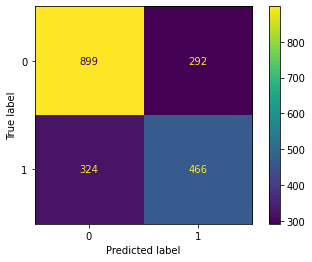

In [878]:
rf = RandomForestClassifier()
rf.fit(imp_training_x, imp_training_y)

predicted_rf = rf.predict(imp_testing_x)

evaluate(imp_testing_y,predicted_rf)

imp_training_x:<br>
Accuracy:  0.689<br>
F1:  0.6021<br>
Recall:  0.5899<br>
precision:  0.6148<br>


I will use F1 for general purpose evavluation of modelling.  The widest training set is providing .6021 F1.  This is my baseline for the random forest algorithm.

random forest with 25 kbest. I want to see how pruning the dataset effects the modelling outputs.

Accuracy:  0.6779
F1:  0.5941
Recall:  0.5911
precision:  0.5972


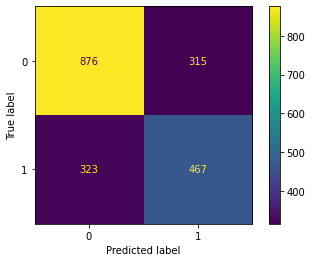

In [879]:
rf = RandomForestClassifier()
rf.fit(X_train_kb25, imp_training_y)

predicted_rf = rf.predict(X_test_kb25)

evaluate(imp_testing_y,predicted_rf)

imp_training_x:<br>
Accuracy:  0.689<br>
F1:  0.6021<br>
Recall:  0.5899<br>
precision:  0.6148<br>

X_train_kb25:<br>
Accuracy:  0.6779<br>
F1:  0.5941<br>
Recall:  0.5911<br>
precision:  0.5972<br>

reducing the dataset provided an negligible improvement in 3 out of 4 metrics.  Recall saw a negligible increase while all other metrics slightly reduded.  Going to continue to restrict features.

Accuracy:  0.6835
F1:  0.6009
Recall:  0.5975
precision:  0.6044


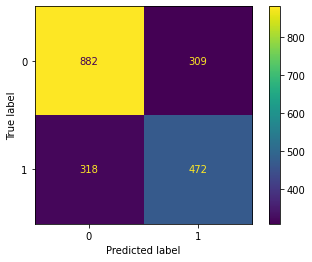

In [891]:
rf = RandomForestClassifier()
rf.fit(X_train_kb20, imp_training_y)

predicted_rf = rf.predict(X_test_kb20)

evaluate(imp_testing_y,predicted_rf)

X_train_kb25:<br>
Accuracy:  0.6779<br>
F1:  0.5941<br>
Recall:  0.5911<br>
precision:  0.5972<br>

X_train_kb20:<br>
Accuracy:  0.6835<br>
F1:  0.6009<br>
Recall:  0.5975<br>
precision:  0.6044<br>

This model saw mild decreases in performance accross all metrics. I am going to proceed with kbest15 to see if this trend continues.

random forest with 15 kbest

Accuracy:  0.6795
F1:  0.5927
Recall:  0.5848
precision:  0.6008


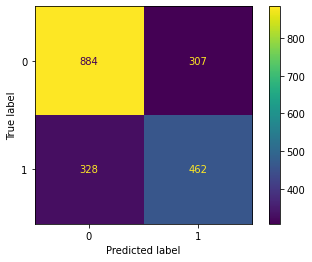

In [893]:
rf = RandomForestClassifier()
rf.fit(X_train_kb15, imp_training_y)

predicted_rf = rf.predict(X_test_kb15)

evaluate(imp_testing_y,predicted_rf)  


X_train_kb20:<br>
Accuracy:  0.6835<br>
F1:  0.6009<br>
Recall:  0.5975<br>
precision:  0.6044<br>

X_train_kb15:<br>
Accuracy:  0.6759<br>
F1:  0.5921<br>
Recall:  0.5899<br>
precision:  0.5944<br>

slight decrease in all metrics.  Possible sweet spot  kbest20

Accuracy:  0.6421
F1:  0.5258
Recall:  0.4975
precision:  0.5574


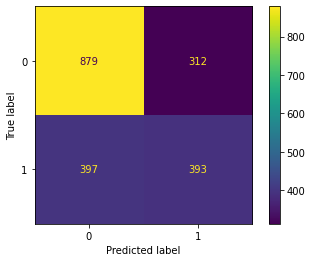

In [894]:
rf = RandomForestClassifier()
rf.fit(holistic_x_train, imp_training_y)

predicted_rf = rf.predict(holistic_x_test)

evaluate(imp_testing_y,predicted_rf)  


X_train_kb15:<br>
Accuracy:  0.6759<br>
F1:  0.5921<br>
Recall:  0.5899<br>
precision:  0.5944<br>

holistic_x_train<br>
Accuracy:  0.6421<br>
F1:  0.5258<br>
Recall:  0.4975<br>
precision:  0.5574<br>

significant drop accross all metrics.  Random forest did not like the 'holistic_x_train' set.  Next going to try scaled set.

Accuracy:  0.6835
F1:  0.5942
Recall:  0.581
precision:  0.6079


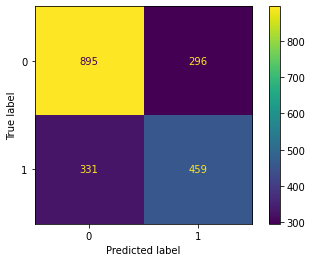

In [897]:
rf = RandomForestClassifier()
rf.fit(X_train_sc, imp_training_y)

predicted_rf = rf.predict(X_test_sc)

evaluate(imp_testing_y,predicted_rf)

X_train_kb20:<br>
Accuracy:  0.6835<br>
F1:  0.6009<br>
Recall:  0.5975<br>
precision:  0.6044<br>

X_train_sc:<br>
Accuracy:  0.6835<br>
F1:  0.5942<br>
Recall:  0.581<br>
precision:  0.6079<br>

feature inclusive scaled set producing similiar results to unscaled kbest20.  going to try and parse the scaled set to the kbest 20 that provided the best metrics and run it.

In [26]:
keep_20 = X_train_kb20.columns

X_train_sc_20 = X_train_sc.loc[:,keep_20]
X_test_sc_20 = X_test_sc.loc[:,keep_20]

#X_train_sc_25.head()

going to go ahead and creat a scaled kbest15 set along similiar lines to have a more parsed and interpretable scaled set.

In [27]:
keep_15 = X_train_kb15.columns
X_train_sc_15 = X_train_sc.loc[:,keep_15]
X_test_sc_15 = X_test_sc.loc[:,keep_15]

In [900]:
X_train_kb15.columns

Index(['risk_factors', 'math_b', 'reading_b', 'writing', 'edu_confidence',
       'math_1', 'math_status_1', 'f1_xcurr', 'hs_gpa', 'testing',
       'v_facility', 'm_facility', 'academic_p', 'iq_by_concientiousness',
       'delinquency'],
      dtype='object')

Accuracy:  0.6769
F1:  0.5929
Recall:  0.5899
precision:  0.5959


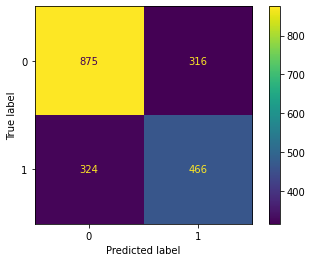

In [901]:
rf = RandomForestClassifier()
rf.fit(X_train_sc_20, imp_training_y)

predicted_rf = rf.predict(X_test_sc_20)

evaluate(imp_testing_y,predicted_rf)

X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6046<br>
Recall:  0.6<br>
precision:  0.6093<br>

X_train_sc_20:<br>
Accuracy:  0.6769<br>
F1:  0.5929<br>
Recall:  0.5899<br>
precision:  0.5959<br>

some mild decreases in performance.  going forward to tuning.

### Tuning random forest

n_estimators = [int(x) for x in range(90, 150, 10)]<br>
max_features = ['auto']<br>
min_samples_split =[2,4,5]<br>
min_samples_leaf = [1,2]<br>
bootstrap = [True, False]<br>

gid search was run in multiple batches to exhaust possibilities.  the following 'param_grid_rf'

In [902]:
param_grid_rf = {
    'n_estimators':[140],
    'max_features':['auto'],
    'max_depth':[8],
    'min_samples_split':[2],
    'min_samples_leaf':[1],
    'bootstrap':[True],
}

In [803]:
rf = RandomForestClassifier(random_state=13)

In [804]:
clf_rf = GridSearchCV(rf, param_grid_rf,return_train_score = True)
clf_rf.fit(X_train_sc_20,imp_training_y)

GridSearchCV(estimator=RandomForestClassifier(random_state=13),
             param_grid={'bootstrap': [True], 'max_depth': [8],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [140]},
             return_train_score=True)

In [805]:
train_score = np.mean(clf_rf.cv_results_['mean_train_score'])
test_score = clf_rf.score(X_test_sc_20, imp_testing_y)
clf_rf.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 140}

Accuracy:  0.6865
F1:  0.6145
Recall:  0.6266
precision:  0.6029


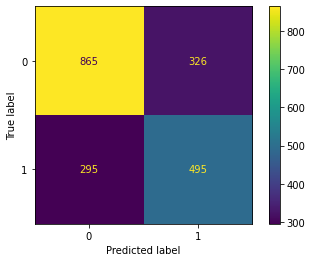

In [903]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_sc_20, imp_training_y)

predicted_rf = rf.predict(X_test_sc_20)

evaluate(imp_testing_y,predicted_rf)

X_train_sc_20:<br>
Accuracy:  0.6769<br>
F1:  0.5929<br>
Recall:  0.5899<br>
precision:  0.5959<br>

tuned X_train_sc_20:<br>
Accuracy:  0.6865<br>
F1:  0.6145<br>
Recall:  0.6266<br>
precision:  0.6029<br>

metrics improved mildly. Recall and consequently F1 saw biggest bumps. When I gridsearched 'bootstrap' the 'False' threw a fail error.  probably because I didn't include 'oob_score' in my gridsearch.  for completeness I am running a model identical to the last but with 'bootstrap' = False.

Accuracy:  0.6865
F1:  0.615
Recall:  0.6278
precision:  0.6027


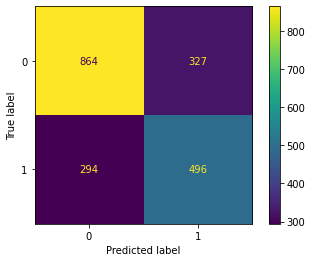

In [906]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_20, imp_training_y)

predicted_rf = rf.predict(X_test_sc_20)

evaluate(imp_testing_y,predicted_rf)

X_train_sc_20:<br>
Accuracy:  0.6769<br>
F1:  0.5929<br>
Recall:  0.5899<br>
precision:  0.5959<br>

tuned X_train_sc_20:<br>
Accuracy:  0.6865<br>
F1:  0.6145<br>
Recall:  0.6266<br>
precision:  0.6029<br>

bootstrap = False:<br>
Accuracy:  0.6865<br>
F1:  0.615<br>
Recall:  0.6278<br>
precision:  0.6027<br>

Negligible differences.  Trying and unscaled version of the data.

Accuracy:  0.687
F1:  0.6149
Recall:  0.6266
precision:  0.6037


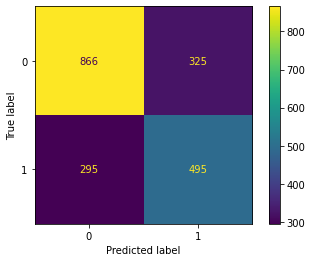

In [907]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_kb20, imp_training_y)

predicted_rf = rf.predict(X_test_kb20)

evaluate(imp_testing_y,predicted_rf)

bootstrap = False:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>

X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

metrics close.  Assuming peformance is close to optimal here.  I will run additional models as expirements to see what results parsed dataset give.  parsed sets can provide better understanding of important features.

Accuracy:  0.688
F1:  0.6166
Recall:  0.6291
precision:  0.6046


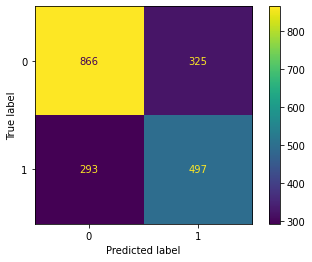

In [908]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_15, imp_training_y)

predicted_rf = rf.predict(X_test_sc_15)

evaluate(imp_testing_y,predicted_rf)

X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

X_train_sc_15:<br>
Accuracy:  0.688<br>
F1:  0.6166<br>
Recall:  0.6291<br>
precision:  0.6046<br>

metrics on 'X_train_sc_15' are negligibly different, assuming close to optimal.  


Accuracy:  0.688
F1:  0.6176
Recall:  0.6316
precision:  0.6041


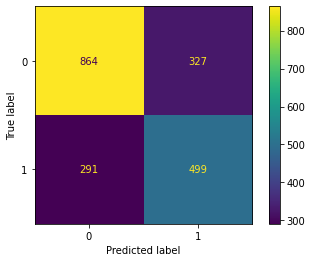

In [909]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_sc_15, imp_training_y)

predicted_rf = rf.predict(X_test_sc_15)

evaluate(imp_testing_y,predicted_rf)

X_train_sc_15:<br>
Accuracy:  0.688<br>
F1:  0.6166<br>
Recall:  0.6291<br>
precision:  0.6046<br>

X_train_sc_15, oob_score = True:<br>
Accuracy:  0.6875<br>
F1:  0.6177<br>
Recall:  0.6329<br>
precision:  0.6031<br>


X_train_sc_15, 'oob_score = True' model negligible differences.

### best random forest

Accuracy:  0.687
F1:  0.6149
Recall:  0.6266
precision:  0.6037


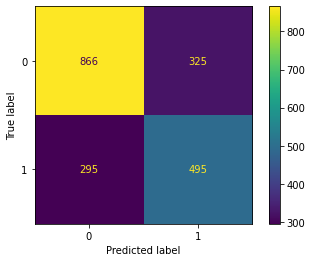

In [917]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_kb20, imp_training_y)

predicted_rf = rf.predict(X_test_kb20)

evaluate(imp_testing_y,predicted_rf)

Baseline:

imp_training_x:<br>
Accuracy:  0.689<br>
F1:  0.6021<br>
Recall:  0.5899<br>
precision:  0.6148<br>

Best:<br>

X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

Some slight increase in performance.  Overall disappionting.  Going to build further parsed down scaled datasets based on feature importances for visualization and future modeling.  

Accuracy:  0.6865
F1:  0.6145
Recall:  0.6266
precision:  0.6029


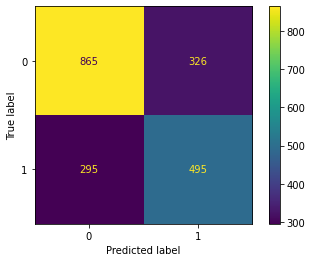

In [51]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_sc_20, imp_training_y)

predicted_rf = rf.predict(X_test_sc_20)

evaluate(imp_testing_y,predicted_rf)

In [52]:
X_train_sc_20.columns

Index(['risk_factors', 'math_b', 'reading_b', 'math_conf_b', 'writing',
       'by_xcurr', 'hedonics_b', 'edu_confidence', 'math_1', 'math_status_1',
       'f1_xcurr', 'math_conf_1', 'hs_gpa', 'effort', 'testing', 'v_facility',
       'm_facility', 'academic_p', 'iq_by_concientiousness', 'delinquency'],
      dtype='object')

<BarContainer object of 20 artists>

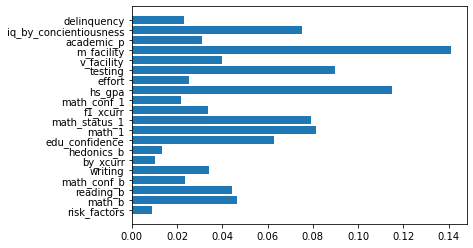

In [54]:
importances = rf.feature_importances_

plt.barh(X_train_sc_20.columns, importances)

creating a set parsed down to 3 so I can build a model that performs this classification task that can be visualized with a 3d scatterplot.  This can give a visual reference for modeling.  Also curious to see how a set parsed down to 3 can perform. many of the features I engineered have other features contained in them.   I am picking features that have minimal redundancy and high relevance to the classification task as revealed by these manipulations.  

In [28]:
keep_3 =  ['hs_gpa', 'm_facility', 'edu_confidence' ]
X_train_sc_3 = X_train_sc.loc[:,keep_3]
X_test_sc_3 = X_test_sc.loc[:,keep_3]

Accuracy:  0.6855
F1:  0.6217
Recall:  0.6481
precision:  0.5974


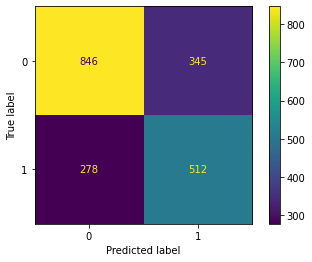

In [923]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_3, imp_training_y)

predicted_rf = rf.predict(X_test_sc_3)

evaluate(imp_testing_y,predicted_rf)

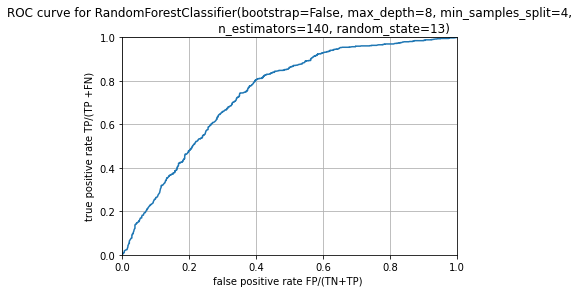

In [645]:
ROC(X_test_sc_3, rf)

X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

X_train_sc_3:<br>
Accuracy:  0.684<br>
F1:  0.6206<br>
Recall:  0.6481<br>
precision:  0.5953<br>

for reference - the baseline model using the most inclusive training set 'imp_training_x'<br>
Baseline:

imp_training_x:<br>
Accuracy:  0.689<br>
F1:  0.6021<br>
Recall:  0.5899<br>
precision:  0.6148<br>

quite surprising that the 3 feature scaled set had this performance.  Pehaps there is some overfitting going on with more inclusive datasets.

edu_confidence = what is highest credential the student expects to complete
m_facility = math standardized testing scores times highest math class completed ordinal
academic_p = high school academic load times high school gpa

### logistic regression

Accuracy:  0.6906
F1:  0.5932
Recall:  0.5658
precision:  0.6234


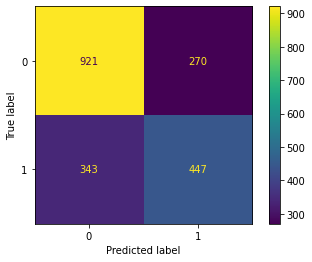

In [926]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(imp_training_x, imp_training_y)

predict_lr = lr.predict(imp_testing_x)

evaluate(imp_testing_y,predict_lr)



baseline logistic regression model using basic and most inclusive training set 'imp_training_x':<br>
Accuracy:  0.6896<br>
F1:  0.5886<br>
Recall:  0.557<br>
precision:  0.6241<br>

for reference the baseline random forest:<br>
imp_training_x:<br>
Accuracy:  0.689<br>
F1:  0.6021<br>
Recall:  0.5899<br>
precision:  0.6148<br>

precision superior, recall inferior F1 inferior, and accuracy superior to random forest baseline.  Continuing with parsed down sets.

Accuracy:  0.6835
F1:  0.5806
Recall:  0.5494
precision:  0.6156


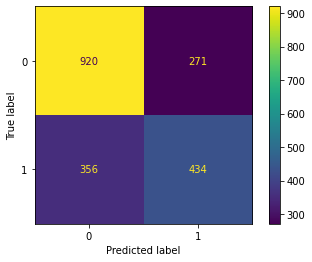

In [927]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_kb25, imp_training_y)

predict_lr = lr.predict(X_test_kb25)

evaluate(imp_testing_y,predict_lr)


imp_training_x:<br>
Accuracy:  0.689<br>
F1:  0.6021<br>
Recall:  0.5899<br>
precision:  0.6148<br>

X_train_kb25:<br>
Accuracy:  0.6835<br>
F1:  0.5806<br>
Recall:  0.5494<br>
precision:  0.6156<br>

Slight drop accross all metrics but precision. Recall dropped most. Will run several more with more curated sets.

Accuracy:  0.6845
F1:  0.5819
Recall:  0.5506
precision:  0.617


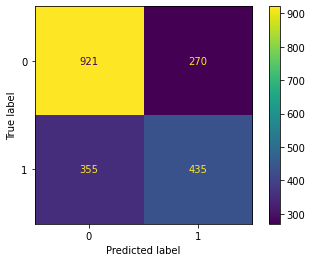

In [930]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_kb20, imp_training_y)

predict_lr = lr.predict(X_test_kb20)

evaluate(imp_testing_y,predict_lr)


X_train_kb25:<br>
Accuracy:  0.6835<br>
F1:  0.5806<br>
Recall:  0.5494<br>
precision:  0.6156<br>

X_train_kb20:<br>
Accuracy:  0.6845<br>
F1:  0.5819<br>
Recall:  0.5506<br>
precision:  0.617<br>

extremely mild increases across all metrics with fewer features.   next: X_train_kb15

Accuracy:  0.6855
F1:  0.5849
Recall:  0.5557
precision:  0.6174


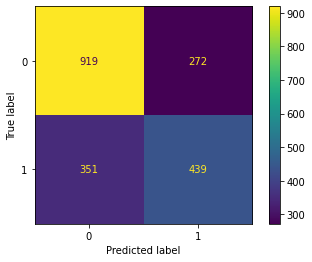

In [932]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_kb15, imp_training_y)

predict_lr = lr.predict(X_test_kb15)

evaluate(imp_testing_y,predict_lr)

X_train_kb20:<br>
Accuracy:  0.6845<br>
F1:  0.5819<br>
Recall:  0.5506<br>
precision:  0.617<br>

X_train_kb15:<br>
Accuracy:  0.6855<br>
F1:  0.5849<br>
Recall:  0.5557<br>
precision:  0.6174<br>

negligible difference accross all metrics.  restriction of features results in no significant loss in preformance.  next: scaled sets

Accuracy:  0.689
F1:  0.5984
Recall:  0.581
precision:  0.6169


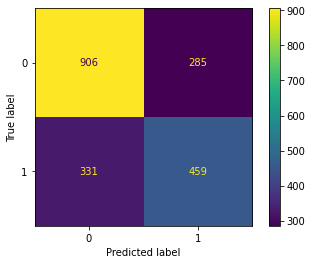

In [1063]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_sc, imp_training_y)

predict_lr = lr.predict(X_test_sc)

evaluate(imp_testing_y,predict_lr)


imp_training_x:<br>
Accuracy:  0.689<br>
F1:  0.6021<br>
Recall:  0.5899<br>
precision:  0.6148<br>

X_train_sc:<br>
Accuracy:  0.689<br>
F1:  0.5984b<br>
Recall:  0.581<br>
precision:  0.6169<br>

No change in accuracy and slight gain in precision.  F1 and recall drop mildly.  Going to try a scaled version of the sweet spot at kbest 20 set.  

Accuracy:  0.6896
F1:  0.5972
Recall:  0.5772
precision:  0.6187


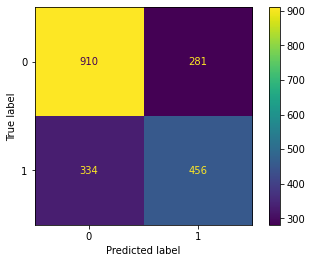

In [935]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_sc_20, imp_training_y)

predict_lr = lr.predict(X_test_sc_20)

evaluate(imp_testing_y,predict_lr)


X_train_sc:<br>
Accuracy:  0.689<br>
F1:  0.5984b<br>
Recall:  0.581<br>
precision:  0.6169<br>

X_train_sc_20:<br>
Accuracy:  0.6896<br>
F1:  0.5972<br>
Recall:  0.5772<br>
precision:  0.6187<br>

negligilble changes accross metrics with restricted features.  So far best results from most inclusive scaled training set.  Next doing 3 feature scaled set just to see results.

Accuracy:  0.6865
F1:  0.5868
Recall:  0.5582
precision:  0.6185


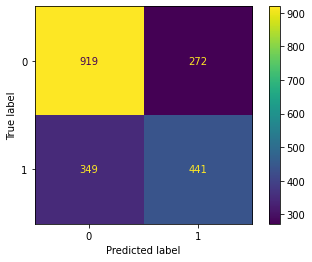

In [938]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_sc_3, imp_training_y)

predict_lr = lr.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_lr)

X_train_sc:<br>
Accuracy:  0.689<br>
F1:  0.5984b<br>
Recall:  0.581<br>
precision:  0.6169<br>

X_train_sc_3:<br>
Accuracy:  0.6865<br>
F1:  0.5868<br>
Recall:  0.5582<br>
precision:  0.6185<br>

mild drops accross all metrics, with most drop coming in recall. Clearly almost all of the usefull data can be found in 3 feature set.  Going to try 15 feature scaled.  

Accuracy:  0.6921
F1:  0.5982
Recall:  0.5747
precision:  0.6236


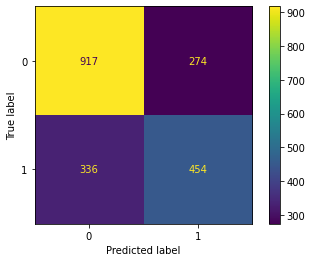

In [1065]:
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train_sc_15, imp_training_y)

predict_lr = lr.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_lr)

X_train_kb15:<br>
Accuracy:  0.6855<br>
F1:  0.5849<br>
Recall:  0.5557<br>
precision:  0.6174<br>

X_train_sc_15<br>
Accuracy:  0.6921<br>
F1:  0.5982<br>
Recall:  0.5747<br>
precision:  0.6236<br>

X_train_sc_3:<br>
Accuracy:  0.6865<br>
F1:  0.5868<br>
Recall:  0.5582<br>
precision:  0.6185<br>

comparison with unscaled 15 feature and scaled 3 feature, thie scaled 15 give best results.  Going to tune with this set.  

### Tuning logistic regression

In [953]:
lr = LogisticRegression(solver='liblinear', random_state=13)

param_grid = {    
    'penalty':['l1','l2'],
    'random_state':[13],
    'C':[1],
    'solver' :['liblinear'], 
    'max_iter':[50,60,70]    
}

In [954]:
clf_lr = GridSearchCV(lr, param_grid, return_train_score = True)
clf_lr.fit(X_train_sc_15, imp_training_y)

GridSearchCV(estimator=LogisticRegression(random_state=13, solver='liblinear'),
             param_grid={'C': [1], 'max_iter': [50, 60, 70],
                         'penalty': ['l1', 'l2'], 'random_state': [13],
                         'solver': ['liblinear']},
             return_train_score=True)

In [955]:
train_score = np.mean(clf_lr.cv_results_['mean_train_score'])
test_score = clf_lr.score(X_test_sc_15, imp_testing_y)
clf_lr.best_params_

{'C': 1,
 'max_iter': 50,
 'penalty': 'l2',
 'random_state': 13,
 'solver': 'liblinear'}

Accuracy:  0.6896
F1:  0.5946
Recall:  0.5709
precision:  0.6204


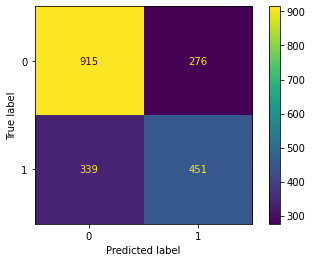

In [960]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 60,random_state=13, C=1,)
lr.fit(X_train_sc_15, imp_training_y)

predict_lr = lr.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_lr)

X_train_sc_15<br>
Accuracy:  0.6921<br>
F1:  0.5982<br>
Recall:  0.5747<br>
precision:  0.6236<br>

tuned 'X_train_sc_15':<br>
Accuracy:  0.6896<br>
F1:  0.5946<br>
Recall:  0.5709<br>
precision:  0.6204<br>

Slight performance drops after tuning.  Will try with reduced feature set.

Accuracy:  0.6865
F1:  0.5868
Recall:  0.5582
precision:  0.6185


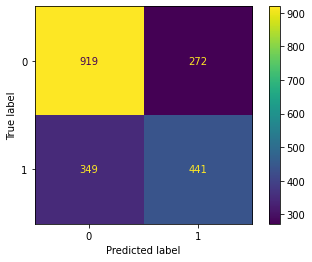

In [961]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 60,random_state=13, C=1,)
lr.fit(X_train_sc_3, imp_training_y)

predict_lr = lr.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_lr)

X_train_sc_15<br>
Accuracy:  0.6921<br>
F1:  0.5982<br>
Recall:  0.5747<br>
precision:  0.6236<br>

X_train_sc_3<br>
Accuracy:  0.6865<br>
F1:  0.5868<br>
Recall:  0.5582<br>
precision:  0.6185<br>

mild drops accross metrics.  clearly most of the classifiction value for this task is coming from these 3 features.  Going to try 3 feature with incresed iterations.

Accuracy:  0.6865
F1:  0.5868
Recall:  0.5582
precision:  0.6185


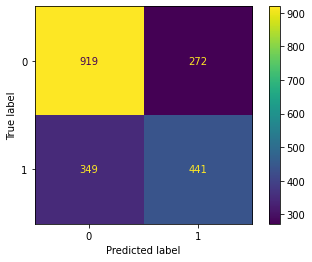

In [962]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(X_train_sc_3, imp_training_y)

predict_lr = lr.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_lr)

best logistic regression:

Accuracy:  0.6896
F1:  0.5946
Recall:  0.5709
precision:  0.6204


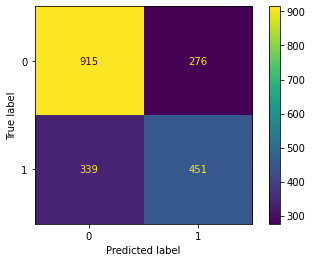

In [963]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 60,random_state=13, C=1,)
lr.fit(X_train_sc_15, imp_training_y)

predict_lr = lr.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_lr)

best random forest:<br>
X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

best logistic regression:<br>
X_train_sc_15<br>
Accuracy:  0.6896<br>
F1:  0.5946<br>
Recall:  0.5709<br>
precision:  0.6204<br>

'X_train_sc_15' produces best model.  random forest superior on this data for F1 and recall.  logistic regression superior for accuracy and precision.   ROC curve for best logistic regression model:

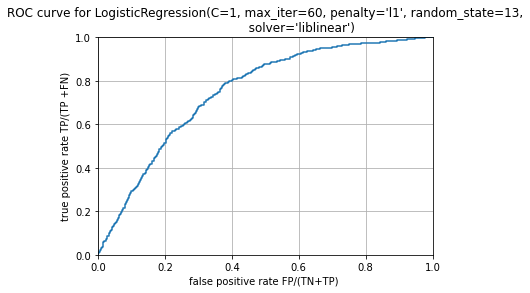

In [965]:
ROC(X_test_sc_15,lr)

### XGBoost

xgboost with most inclusive set

Accuracy:  0.6865
F1:  0.614
Recall:  0.6253
precision:  0.6032


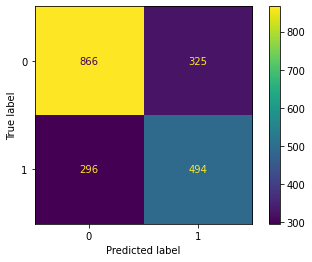

In [966]:
xgb = XGBClassifier()
xgb.fit(imp_training_x,imp_training_y)

predict_xgb = xgb.predict(imp_testing_x)
 
evaluate(imp_testing_y,predict_xgb)

baseline xgboost:<br>
Accuracy:  0.6865<br>
F1:  0.614<br>
Recall:  0.6253<br>
precision:  0.6032<br>

moving on with pruned sets.  next xgboost with 25 kbest

Accuracy:  0.681
F1:  0.6079
Recall:  0.6203
precision:  0.5961


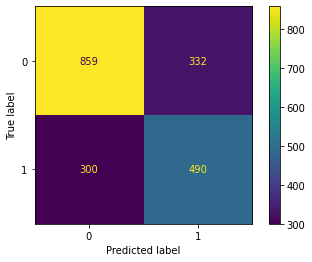

In [967]:
xgb = XGBClassifier()
xgb.fit(X_train_kb25,imp_training_y)

predict_xgb = xgb.predict(X_test_kb25)
 
evaluate(imp_testing_y,predict_xgb)

imp_training_x<br>
Accuracy:  0.6865<br>
F1:  0.614<br>
Recall:  0.6253<br>
precision:  0.6032<br>

X_train_kb25<br>
Accuracy:  0.681<br>
F1:  0.6079<br>
Recall:  0.6203<br>
precision:  0.5961<br>
<br>

Slight performance reduction with more restricted dataset.  Will continue to reduce features.

xgboost with 20 kbest

Accuracy:  0.683
F1:  0.6114
Recall:  0.6253
precision:  0.5981


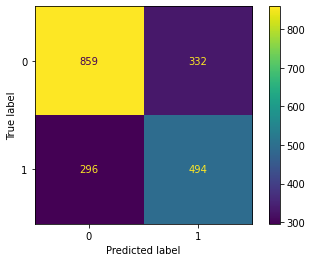

In [968]:
xgb = XGBClassifier()
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

imp_training_x<br>
Accuracy:  0.6865<br>
F1:  0.614<br>
Recall:  0.6253<br>
precision:  0.6032<br>

X_train_kb25<br>
Accuracy:  0.681<br>
F1:  0.6079<br>
Recall:  0.6203<br>
precision:  0.5961<br>

X_train_kb20<br>
Accuracy:  0.683<br>
F1:  0.6114<br>
Recall:  0.6253<br>
precision:  0.5981<br>

Kbest20 slight improvement over kbest25 and still slightly inferior to imp_training_x.  Next kbest 15 to see if dimensionality reduction continues to improve.

Accuracy:  0.6805
F1:  0.61
Recall:  0.6266
precision:  0.5942


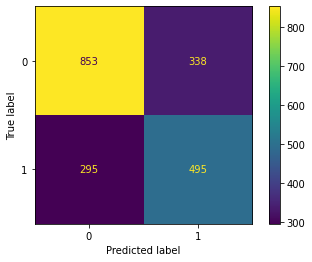

In [969]:
xgb = XGBClassifier()
xgb.fit(X_train_kb15,imp_training_y)

predict_xgb = xgb.predict(X_test_kb15)
 
evaluate(imp_testing_y,predict_xgb)

X_train_kb20<br>
Accuracy:  0.683<br>
F1:  0.6114<br>
Recall:  0.6253<br>
precision:  0.5981<br>

X_train_kb15<br>
Accuracy:  0.6805<br>
F1:  0.61<br>
Recall:  0.6266<br>
precision:  0.5942<br>

extremely mild performance changes.  Trying scaled sets.

Accuracy:  0.6865
F1:  0.614
Recall:  0.6253
precision:  0.6032


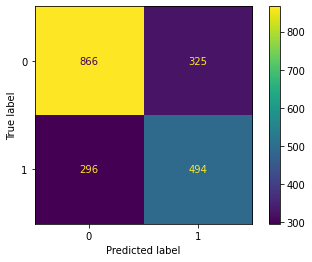

In [970]:
xgb = XGBClassifier()
xgb.fit(X_train_sc,imp_training_y)

predict_xgb = xgb.predict(X_test_sc)
 
evaluate(imp_testing_y,predict_xgb)

X_train_imp:<br>
Accuracy:  0.6865<br>
F1:  0.614<br>
Recall:  0.6253<br>
precision:  0.6032<br>

X_train_sc<br>
Accuracy:  0.6865<br>
F1:  0.614<br>
Recall:  0.6253<br>
precision:  0.6032<br>

same performance.  Going to try further reduction in features.  

xgboost with scaled training set

Accuracy:  0.683
F1:  0.6114
Recall:  0.6253
precision:  0.5981


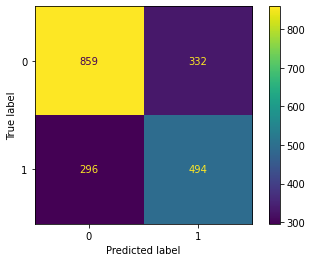

In [971]:
xgb = XGBClassifier()
xgb.fit(X_train_sc_20,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_20)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc<br>
Accuracy:  0.6865<br>
F1:  0.614<br>
Recall:  0.6253<br>
precision:  0.6032<br>

X_train_sc_20<br>
Accuracy:  0.683<br>
F1:  0.6114<br>
Recall:  0.6253<br>
precision:  0.5981<br>

extremely mild performance loss.  continuing to restrict dimensions.

Accuracy:  0.6805
F1:  0.61
Recall:  0.6266
precision:  0.5942


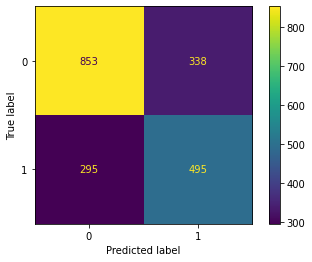

In [972]:
xgb = XGBClassifier()
xgb.fit(X_train_sc_15,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_15)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc_20<br>
Accuracy:  0.683<br>
F1:  0.6114<br>
Recall:  0.6253<br>
precision:  0.5981<br>

X_train_sc_15<br>
Accuracy:  0.6805<br>
F1:  0.61<br>
Recall:  0.6266<br>
precision:  0.5942<br>

extremely mild performance loss.  contining to restrict features to 3.

Accuracy:  0.6815
F1:  0.6145
Recall:  0.6367
precision:  0.5939


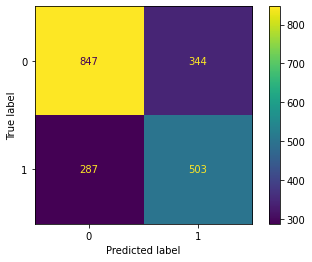

In [975]:
xgb = XGBClassifier()
xgb.fit(X_train_sc_3,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_3)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc_15<br>
Accuracy:  0.6805<br>
F1:  0.61<br>
Recall:  0.6266<br>
precision:  0.5942<br>


X_train_sc_3<br>
Accuracy:  0.6815<br>
F1:  0.6145<br>
Recall:  0.6367<br>
precision:  0.5939<br>

Highly unexpected.  Most restrictive dataset with only three features provides marginally better performance.  Most of the classification coming from these 3 features.  Moving on to tuning.

### tuning xgboost

In [816]:
# param_grid_xgb = {
#     "n_estimators"     : [70,80,90,110,130,150],
#     'subsample'        : [.7,.8,.9],
#     "learning_rate"    : [.1,.2,.3] ,
#     "max_depth"        : [2,3,4,5],
#     "min_child_weight" : [3,4,5,6,7],
#     "gamma"            : [0.1,.15,.2,.3],
#     "colsample_bytree" : [0.6,.7,.8] 
#     }

started with the above parameter and pruned to these

In [976]:
param_grid_xgb = {
    "n_estimators"     : [90],
    'subsample'        : [.9],
    "learning_rate"    : [.2] ,
    "max_depth"        : [2],
    "gamma"            : [.2],
    "colsample_bytree" : [.7] 
    }

In [977]:
clf_xgb = GridSearchCV(xgb, param_grid_xgb,return_train_score = True)
clf_xgb.fit(X_train_sc_3,imp_training_y)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'colsample_bytree': [0.7], 'gamma': [0.2],
                         'learning_rate': [0.2], 'max_depth': [2],
                         'n_estimators': [90], 'subsample': [0.9]},
             return_train_score=True)

In [978]:
train_score = np.mean(clf_xgb.cv_results_['mean_train_score'])
test_score = clf_xgb.score(X_test_sc_3, imp_testing_y)
clf_xgb.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.2,
 'max_depth': 2,
 'n_estimators': 90,
 'subsample': 0.9}

Accuracy:  0.6875
F1:  0.6162
Recall:  0.6291
precision:  0.6039


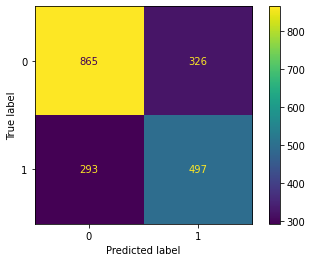

In [979]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_sc_3,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_3)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc_3<br>
Accuracy:  0.6815<br>
F1:  0.6145<br>
Recall:  0.6367<br>
precision:  0.5939<br>

X_train_sc_3 - tuned:<br>
Accuracy:  0.6875<br>
F1:  0.6162<br>
Recall:  0.6291<br>
precision:  0.6039<br>

tuning yields some improvement.  Slight increase in precision and accuracy and F1 while recall reduced slightly.

slight loss in performance on accuracy but gain in other metrics with kbest15 after tuning.

Accuracy:  0.689
F1:  0.6183
Recall:  0.6316
precision:  0.6056


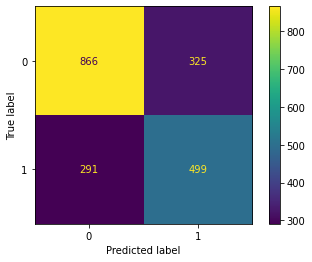

In [984]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_sc_20,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_20)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc_3:<br>
Accuracy:  0.6875<br>
F1:  0.6162<br>
Recall:  0.6291<br>
precision:  0.6039<br>

X_train_sc_20<br>
Accuracy:  0.689<br>
F1:  0.6183<br>
Recall:  0.6316<br>
precision:  0.6056<br>

3 feature mosel still gives comparable, but slightly inferior performance over 20 feature set.   Trying 15 feature set next.  

Accuracy:  0.682
F1:  0.6106
Recall:  0.6253
precision:  0.5966


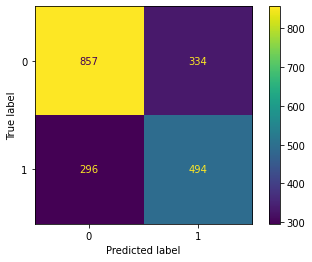

In [985]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_sc_15,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_15)
 
evaluate(imp_testing_y,predict_xgb)

X_train_sc_3:<br>
Accuracy:  0.6875<br>
F1:  0.6162<br>
Recall:  0.6291<br>
precision:  0.6039<br>

X_train_sc_20<br>
Accuracy:  0.689<br>
F1:  0.6183<br>
Recall:  0.6316<br>
precision:  0.6056<br>

X_train_sc_15:<br>
Accuracy:  0.682<br>
F1:  0.6106<br>
Recall:  0.6253<br>
precision:  0.5966<br>

Definitely best metrics yet from X_train_sc_20.  Every metric is superior to models run previously.  3 feature model slight bias.

#### best xgboost:

Accuracy:  0.689
F1:  0.6183
Recall:  0.6316
precision:  0.6056


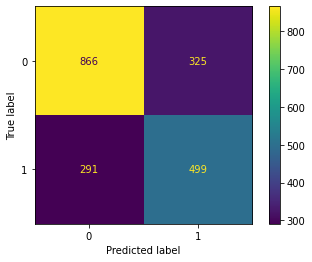

In [986]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

Using inbuilt xgboost feature importances to compare to random forest feature importances.

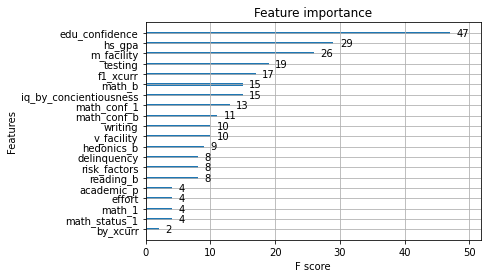

In [987]:
plot_importance(xgb)
plt.show()

xgb importances showing similiar high impact features as random forest importances.

this was the best performance with xgboost.<br>
X_train_sc_20<br>
Accuracy:  0.689<br>
F1:  0.6183<br>
Recall:  0.6316<br>
precision:  0.6056<br>

compared with performance with scaled dataset with only 3 featrues:<br>

X_train_sc_3:<br>
Accuracy:  0.6875<br>
F1:  0.6162<br>
Recall:  0.6291<br>
precision:  0.6039<br>

xgboost performs almost as well on this data with a dataset with only 3 features as it does on set with 20.  and compared to the best model from random forest and logistic regression:<br>

best random forest:<br>
X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

best logistic regression:<br>
X_train_sc_15<br>
Accuracy:  0.6896<br>
F1:  0.5946<br>
Recall:  0.5709<br>
precision:  0.6204<br>


at this point xgboost is providing the best performance.

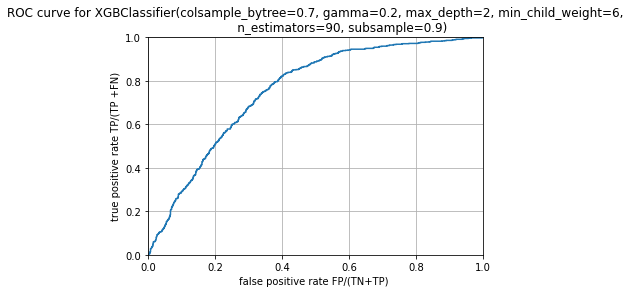

In [988]:
ROC(X_test_kb20,xgb)

### Gaussian Naive Bayes

Accuracy:  0.6764
F1:  0.6581
Recall:  0.781
precision:  0.5687


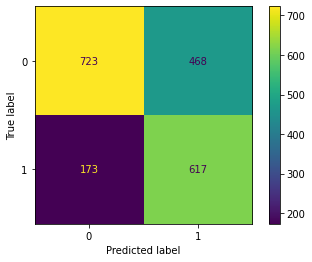

In [991]:
gnb = GaussianNB()

gnb.fit(imp_training_x,imp_training_y)

predict_gnb = gnb.predict(imp_testing_x)

evaluate(imp_testing_y,predict_gnb)

baseline model:<br>
Accuracy:  0.6764<br>
F1:  0.6581<br>
Recall:  0.781<br>
precision:  0.5687<br>

baseline model providing best recall, lower precision, modest F1 and accuracy.  going to run progressively trimmed series of sets.

Accuracy:  0.6749
F1:  0.6454
Recall:  0.7418
precision:  0.5712


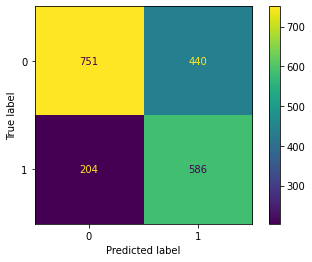

In [730]:
gnb = GaussianNB()

gnb.fit(X_train_kb25,imp_training_y)

predict_gnb = gnb.predict(X_test_kb25)

evaluate(imp_testing_y,predict_gnb)

baseline model:<br>
Accuracy:  0.6764<br>
F1:  0.6581<br>
Recall:  0.781<br>
precision:  0.5687<br>

X_train_kb25<br>
Accuracy:  0.6749<br>
F1:  0.6454<br>
Recall:  0.7418<br>
precision:  0.5712<br>

drop in metrics especially recall.  Precision improved slightly.  continuing to reduce features.

Accuracy:  0.6689
F1:  0.6392
Recall:  0.7354
precision:  0.5652


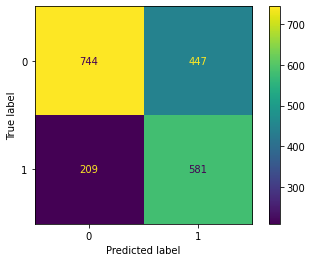

In [992]:
gnb = GaussianNB()

gnb.fit(X_train_kb20,imp_training_y)

predict_gnb = gnb.predict(X_test_kb20)

evaluate(imp_testing_y,predict_gnb)

X_train_kb25<br>
Accuracy:  0.6749<br>
F1:  0.6454<br>
Recall:  0.7418<br>
precision:  0.5712<br>

X_train_kb20<br>
Accuracy:  0.6689<br>
F1:  0.6392<br>
Recall:  0.7354<br>
precision:  0.5652<br>

further reducing metrics with reduced dimensionality.  

Accuracy:  0.6689
F1:  0.6431
Recall:  0.7481
precision:  0.5639


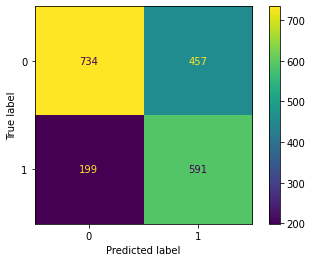

In [998]:
gnb = GaussianNB()

gnb.fit(X_train_kb15,imp_training_y)

predict_gnb = gnb.predict(X_test_kb15)

evaluate(imp_testing_y,predict_gnb)

X_train_kb20<br>
Accuracy:  0.6689<br>
F1:  0.6392<br>
Recall:  0.7354<br>
precision:  0.5652<br>

X_train_kb15<br>
Accuracy:  0.6689<br>
F1:  0.6431<br>
Recall:  0.7481<br>
precision:  0.5639<br>

surprised to see imrpvement in accuracy, F1, and recall.  Possible overfit with more features.  Trying scaled sets.

Accuracy:  0.6416
F1:  0.6421
Recall:  0.8063
precision:  0.5335


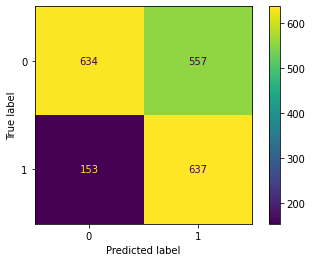

In [1000]:
gnb = GaussianNB()

gnb.fit(X_train_sc,imp_training_y)

predict_gnb = gnb.predict(X_test_sc)

evaluate(imp_testing_y,predict_gnb)

baseline model:<br>
Accuracy:  0.6764<br>
F1:  0.6581<br>
Recall:  0.781<br>
precision:  0.5687<br>

X_train_sc<br>
Accuracy:  0.6416<br>
F1:  0.6421<br>
Recall:  0.8063<br>
precision:  0.5335<br>

Compared with unscaled set with same features, accuracy, precision and F1 drops significanlty while recall improves significanlty.  Going to try and restrict features with scaled sets.  

Accuracy:  0.6694
F1:  0.6383
Recall:  0.7316
precision:  0.5661


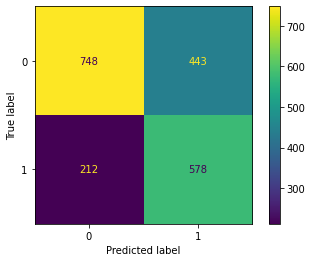

In [1001]:
gnb = GaussianNB()

gnb.fit(X_train_sc_20,imp_training_y)

predict_gnb = gnb.predict(X_test_sc_20)

evaluate(imp_testing_y,predict_gnb)

X_train_sc<br>
Accuracy:  0.6416<br>
F1:  0.6421<br>
Recall:  0.8063<br>
precision:  0.5335<br>

X_train_sc_20<br>
Accuracy:  0.6694<br>
F1:  0.6383<br>
Recall:  0.7316<br>
precision:  0.5661<br>

Reduced features gives handsome increases in precision and accuracy, but drps in recall and F1.  Continuing to restrict data.

Accuracy:  0.6699
F1:  0.6434
Recall:  0.7468
precision:  0.5651


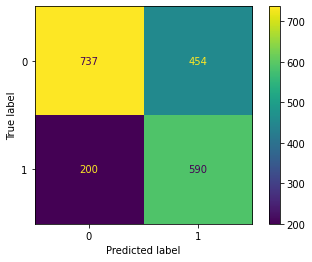

In [1003]:
gnb = GaussianNB()

gnb.fit(X_train_sc_15,imp_training_y)

predict_gnb = gnb.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_gnb)

X_train_sc_20<br>
Accuracy:  0.6694<br>
F1:  0.6383<br>
Recall:  0.7316<br>
precision:  0.5661<br>

X_train_sc_15<br>
Accuracy:  0.6699<br>
F1:  0.6434<br>
Recall:  0.7468<br>
precision:  0.5651<br>

Some improvement with more restriction.  Going to three feature set.  

Accuracy:  0.6835
F1:  0.6511
Recall:  0.7405
precision:  0.5809


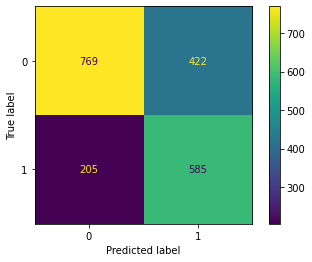

In [1002]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_gnb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

X_train_sc<br>
Accuracy:  0.6416<br>
F1:  0.6421<br>
Recall:  0.8063<br>
precision:  0.5335<br>

X_train_sc_20<br>
Accuracy:  0.6694<br>
F1:  0.6383<br>
Recall:  0.7316<br>
precision:  0.5661<br>

X_train_sc_15<br>
Accuracy:  0.6699<br>
F1:  0.6434<br>
Recall:  0.7468<br>
precision:  0.5651<br>

X_train_sc_3<br>
Accuracy:  0.6835<br>
F1:  0.6511<br>
Recall:  0.7405<br>
precision:  0.5809<br>

most restricted feature sets produces best results in naive bayes on these data.  

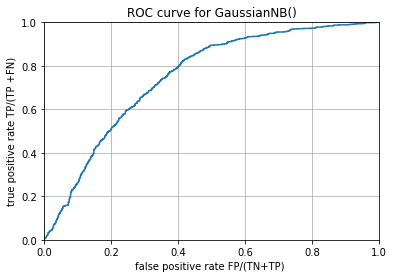

In [831]:
ROC(X_test_sc_3, gnb)

best gaussian naive bayes:
X_train_sc_3<br>
Accuracy:  0.6835<br>
F1:  0.6511<br>
Recall:  0.7405<br>
precision:  0.5809<br>

best random forest:<br>
X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

best logistic regression:<br>
X_train_sc_15<br>
Accuracy:  0.6896<br>
F1:  0.5946<br>
Recall:  0.5709<br>
precision:  0.6204<br>

xgboost:<br>
X_train_sc_20<br>
Accuracy:  0.689<br>
F1:  0.6183<br>
Recall:  0.6316<br>
precision:  0.6056<br>

best recall and F1 yet with naive bayes. Especially impressive when viewed in light of it using 3 feature dataset.  Going to Knn next.  Anticipate scaled set more effective here as the algorithm relies on distance calculations and scaling normalizes these distances.

### KNN

Accuracy:  0.6265
F1:  0.517
Recall:  0.5013
precision:  0.5337


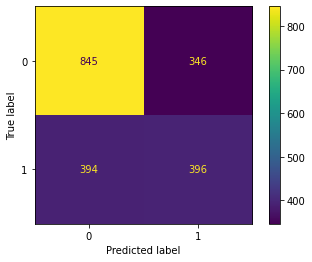

In [1012]:
knn = KNeighborsClassifier()

knn.fit(imp_training_x,imp_training_y)

predict_knn = knn.predict(imp_testing_x)

evaluate(imp_testing_y,predict_knn)

baseline model with imp_training_x:<br>
Accuracy:  0.6265<br>
F1:  0.517<br>
Recall:  0.5013<br>
precision:  0.5337<br>

modest initial performance poor.  Hoping scaled sets improve performance.  

Accuracy:  0.6441
F1:  0.5677
Recall:  0.5861
precision:  0.5505


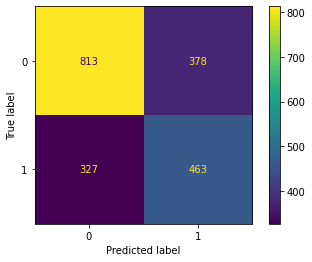

In [1013]:
knn = KNeighborsClassifier()

knn.fit(X_train_sc,imp_training_y)

predict_knn = knn.predict(X_test_sc)

evaluate(imp_testing_y,predict_knn)

baseline model with imp_training_x:<br>
Accuracy:  0.6265<br>
F1:  0.517<br>
Recall:  0.5013<br>
precision:  0.5337<br>

X_train_sc<br>
Accuracy:  0.6441<br>
F1:  0.5677<br>
Recall:  0.5861<br>
precision:  0.5505<br>

scaled yields handsome improvement in all metrics.   running unscaled set pruned to 25 features.

Accuracy:  0.6567
F1:  0.5755
Recall:  0.5835
precision:  0.5677


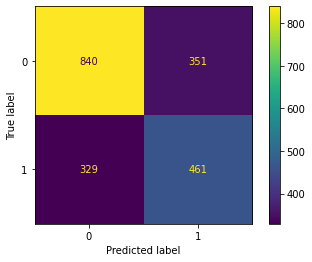

In [1019]:
knn = KNeighborsClassifier()

knn.fit(X_train_sc_20,imp_training_y)

predict_knn = knn.predict(X_test_sc_20)

evaluate(imp_testing_y,predict_knn)

X_train_sc<br>
Accuracy:  0.6441<br>
F1:  0.5677<br>
Recall:  0.5861<br>
precision:  0.5505<br>

X_train_sc_20<br>
Accuracy:  0.6567<br>
F1:  0.5755<br>
Recall:  0.5835<br>
precision:  0.5677<br>

Performance improves.  more features possible overfit.   Continuing to restrict features.

Accuracy:  0.6527
F1:  0.5673
Recall:  0.5709
precision:  0.5638


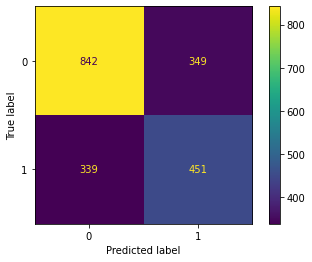

In [1021]:
knn = KNeighborsClassifier()

knn.fit(X_train_sc_15,imp_training_y)

predict_knn = knn.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_knn)

X_train_sc_20<br>
Accuracy:  0.6567<br>
F1:  0.5755<br>
Recall:  0.5835<br>
precision:  0.5677<br>

X_train_sc_15<br>
Accuracy:  0.6527<br>
F1:  0.5673<br>
Recall:  0.5709<br>
precision:  0.5638<br>

mild performance drops as number of features gets smaller.  Going to 3 feature scaled just to see.

Accuracy:  0.6532
F1:  0.5576
Recall:  0.5481
precision:  0.5675


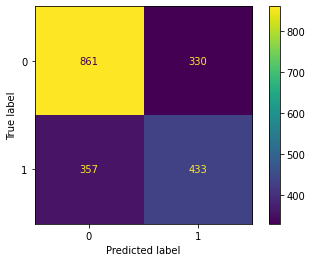

In [1023]:
knn = KNeighborsClassifier()

knn.fit(X_train_sc_3,imp_training_y)

predict_knn = knn.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_knn)

X_train_sc_15<br>
Accuracy:  0.6527<br>
F1:  0.5673<br>
Recall:  0.5709<br>
precision:  0.5638<br>

X_train_sc_3<br>
Accuracy:  0.6532<br>
F1:  0.5576<br>
Recall:  0.5481<br>
precision:  0.5675<br>

Mild drops accross metrics given 80% reduction in features.
comparision with best knn:<br>

X_train_sc_20<br>
Accuracy:  0.6567<br>
F1:  0.5755<br>
Recall:  0.5835<br>
precision:  0.5677<br>

in comparision to outputs from other models the performance of knn on these data is poor so far.  Will try to tune.

beast gaussian naive bayes:
X_train_sc_3<br>
Accuracy:  0.6835<br>
F1:  0.6511<br>
Recall:  0.7405<br>
precision:  0.5809<br>

best random forest:<br>
X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

best logistic regression:<br>
X_train_sc_15<br>
Accuracy:  0.6896<br>
F1:  0.5946<br>
Recall:  0.5709<br>
precision:  0.6204<br>

xgboost:<br>
X_train_sc_20<br>
Accuracy:  0.689<br>
F1:  0.6183<br>
Recall:  0.6316<br>
precision:  0.6056<br>



In [582]:
# param_grid_knn = {
#     'n_neighbors':list(range(50,150,10)), 
#     'leaf_size':[1,2,3], 
#     "p":[1,2,3,4,5],  

#     }

above prams were initial searchspace. trimmed to set below.

In [1024]:
param_grid_knn = {
    'n_neighbors':[110], 
    'leaf_size':[1], 
    "p":[3],  

    }

In [1027]:
clf_knn = GridSearchCV(knn, param_grid_knn, cv = 5)
clf_knn.fit(X_train_sc_20, imp_training_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1], 'n_neighbors': [110], 'p': [3]})

In [1028]:
#train_score = np.mean(clf_knn.cv_results_['mean_train_score'])
test_score = clf_knn.score(X_test_sc_20, imp_testing_y)
clf_knn.best_params_

{'leaf_size': 1, 'n_neighbors': 110, 'p': 3}

Accuracy:  0.683
F1:  0.6226
Recall:  0.6557
precision:  0.5927


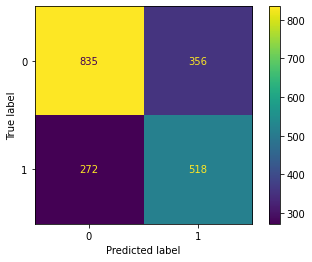

In [1029]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_20,imp_training_y)

predict_knn = knn.predict(X_test_sc_20)

evaluate(imp_testing_y,predict_knn)


X_train_sc_20<br>
Accuracy:  0.6567<br>
F1:  0.5755<br>
Recall:  0.5835<br>
precision:  0.5677<br>

X_train_sc_20 - tuned:<br>
Accuracy:  0.683<br>
F1:  0.6226<br>
Recall:  0.6557<br>
precision:  0.5927<br>

substantive improvement accross all metrics. going to try more restricted sets to maximize interpretability.

scaling gives best performance gain on KNN.  possibly becasue the algorithm relies on distance measures and standard scaling takes noise out of distances

Accuracy:  0.6815
F1:  0.6224
Recall:  0.6582
precision:  0.5902


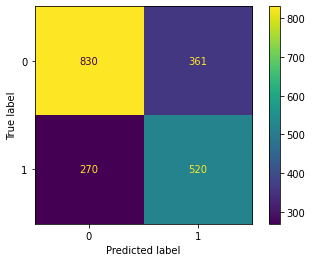

In [1030]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_15,imp_training_y)

predict_knn = knn.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_knn)

X_train_sc_20 - tuned:<br>
Accuracy:  0.683<br>
F1:  0.6226<br>
Recall:  0.6557<br>
precision:  0.5927<br>

X_train_sc_15:<br>
Accuracy:  0.6815<br>
F1:  0.6224<br>
Recall:  0.6582<br>
precision:  0.5902<br>

negligible improvement across metrics.  going to restrict features to 3.

Accuracy:  0.6784
F1:  0.6001
Recall:  0.6051
precision:  0.5953


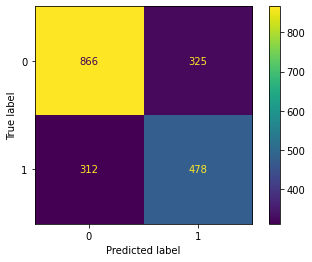

In [1031]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_3,imp_training_y)

predict_knn = knn.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_knn)

X_train_sc_15:<br>
Accuracy:  0.6815<br>
F1:  0.6224<br>
Recall:  0.6582<br>
precision:  0.5902<br>

X_train_sc_3:<br>
Accuracy:  0.6784<br>
F1:  0.6001<br>
Recall:  0.6051<br>
precision:  0.5953<br>

significant decrease in F1 and recall,  some loss in accuracy.  

### best knn

Accuracy:  0.683
F1:  0.6226
Recall:  0.6557
precision:  0.5927


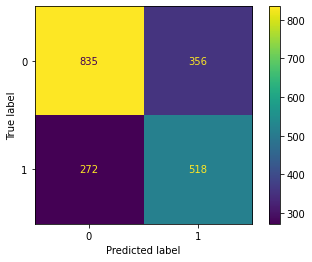

In [1032]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_20,imp_training_y)

predict_knn = knn.predict(X_test_sc_20)

evaluate(imp_testing_y,predict_knn)

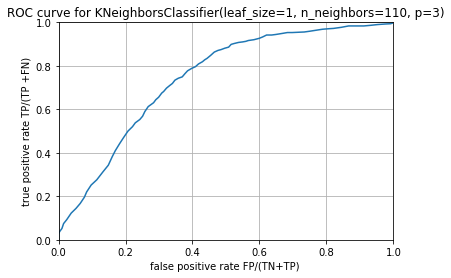

In [1033]:
ROC(X_test_sc_20,knn)

best knn: <br>
X_train_sc_20 - tuned:<br>
Accuracy:  0.683<br>
F1:  0.6226<br>
Recall:  0.6557<br>
precision:  0.5927<br>

beast gaussian naive bayes:
X_train_sc_3<br>
Accuracy:  0.6835<br>
F1:  0.6511<br>
Recall:  0.7405<br>
precision:  0.5809<br>

best random forest:<br>
X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

best logistic regression:<br>
X_train_sc_15<br>
Accuracy:  0.6896<br>
F1:  0.5946<br>
Recall:  0.5709<br>
precision:  0.6204<br>

xgboost:<br>
X_train_sc_20<br>
Accuracy:  0.689<br>
F1:  0.6183<br>
Recall:  0.6316<br>
precision:  0.6056<br>

knn with 3 feature set yields:<br>

X_train_sc_3<br>
Accuracy:  0.6784<br>
F1:  0.6036<br>
Recall:  0.6139<br>
precision:  0.5936<br>



### Best Models

### Best Random Forest

This section is a curation of the best of each of the five models explored:  Random Forest, Logistic Regression, XGBoost, Gaussian Naive Bayes, and KNN.

Accuracy:  0.687
F1:  0.6149
Recall:  0.6266
precision:  0.6037


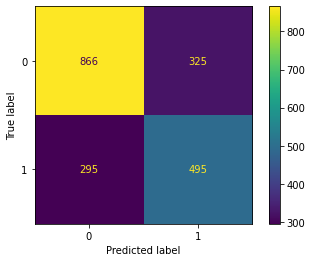

In [1070]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_kb20, imp_training_y)

predicted_rf = rf.predict(X_test_kb20)

evaluate(imp_testing_y,predicted_rf)

In [1071]:
probs_rf = rf.predict_proba(X_test_kb20)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(imp_testing_y, probs_rf)
auc_rf = auc(recall_rf, precision_rf)

### Best Logistic Regression

Accuracy:  0.6896
F1:  0.5946
Recall:  0.5709
precision:  0.6204


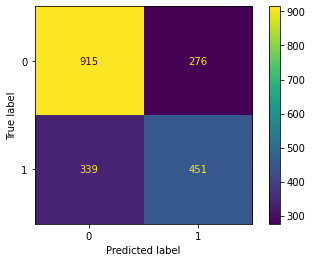

In [1072]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 60,random_state=13, C=1,)
lr.fit(X_train_sc_15, imp_training_y)

predict_lr = lr.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_lr)

In [1073]:
probs_lr = lr.predict_proba(X_test_sc_15)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(imp_testing_y, probs_lr)
auc_lr = auc(recall_lr, precision_lr)

### Best XGBoost

Accuracy:  0.689
F1:  0.6183
Recall:  0.6316
precision:  0.6056


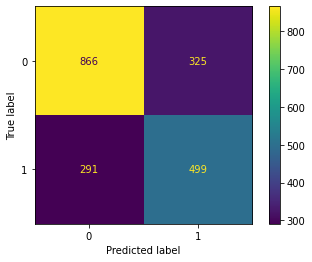

In [1074]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

In [1075]:
probs_xgb = xgb.predict_proba(X_test_kb20)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(imp_testing_y, probs_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)

## gaussian naive bayes

Accuracy:  0.6835
F1:  0.6511
Recall:  0.7405
precision:  0.5809


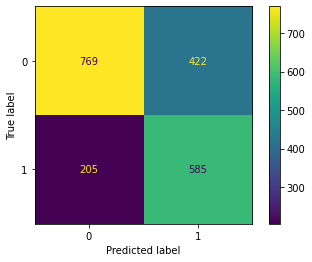

In [1076]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_gnb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

In [1077]:
probs_gnb= gnb.predict_proba(X_test_sc_3)[:, 1]
precision_gnb, recall_gnb, _ = precision_recall_curve(imp_testing_y, probs_gnb)
auc_gnb = auc(recall_gnb, precision_gnb)

### Best KNN

Accuracy:  0.683
F1:  0.6226
Recall:  0.6557
precision:  0.5927


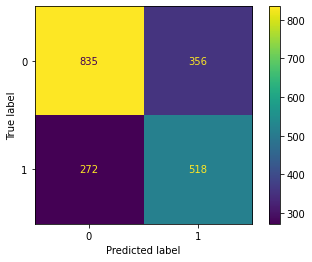

In [1078]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_20,imp_training_y)

predict_knn = knn.predict(X_test_sc_20)

evaluate(imp_testing_y,predict_knn)

In [1079]:
probs_knn = knn.predict_proba(X_test_sc_20)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(imp_testing_y, probs_knn)
auc_knn = auc(recall_knn, precision_knn)

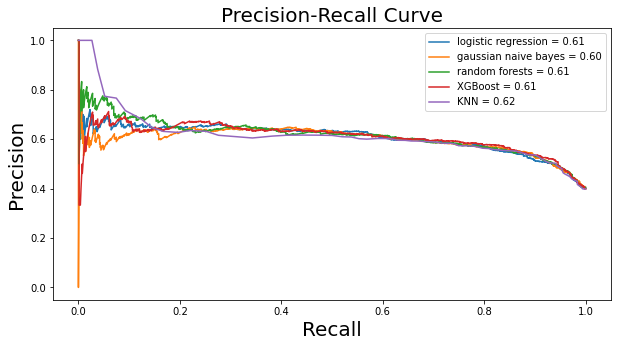

In [1080]:
plt.figure(figsize=(10, 5))
plt.plot(recall_lr, precision_lr, label=f'logistic regression = {auc_lr:.2f}')
plt.plot(recall_gnb, precision_gnb, label=f'gaussian naive bayes = {auc_gnb:.2f}')
plt.plot(recall_rf, precision_rf, label=f'random forests = {auc_rf:.2f}')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost = {auc_xgb:.2f}')
plt.plot(recall_knn, precision_knn, label=f'KNN = {auc_knn:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=20)
plt.ylabel('Precision', size=20)
plt.legend();

precision recall curves are usefull tool for model evaluation because they visualize how the model is trading off classifying true positives(precision) for a given false negative classification (recall) among different models.  These models are all performing comparably with this trade off.  Best F1 was achieved with gaussian naive bayes with a most parsimonious 3 feature data set.  I am evaluating gaussian naive bayes to be the best model even though the precision recall curve shows comparable performance across the models tested. 

best knn: <br>
X_train_sc_20 - tuned:<br>
Accuracy:  0.683<br>
F1:  0.6226<br>
Recall:  0.6557<br>
precision:  0.5927<br>

beast gaussian naive bayes:
X_train_sc_3<br>
Accuracy:  0.6835<br>
F1:  0.6511<br>
Recall:  0.7405<br>
precision:  0.5809<br>

best random forest:<br>
X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

best logistic regression:<br>
X_train_sc_15<br>
Accuracy:  0.6896<br>
F1:  0.5946<br>
Recall:  0.5709<br>
precision:  0.6204<br>

xgboost:<br>
X_train_sc_20<br>
Accuracy:  0.689<br>
F1:  0.6183<br>
Recall:  0.6316<br>
precision:  0.6056<br>

### 3 Feature Models

all models performing comparably in trading off precision and recall.  as comparison I am going to construct a precision recall curve for best 3 featrue models

Accuracy:  0.6855
F1:  0.6217
Recall:  0.6481
precision:  0.5974


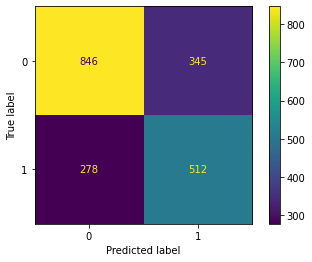

In [1045]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_3, imp_training_y)

predicted_rf = rf.predict(X_test_sc_3)

evaluate(imp_testing_y,predicted_rf)

In [1046]:
probs_rf = rf.predict_proba(X_test_sc_3)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(imp_testing_y, probs_rf)
auc_rf = auc(recall_rf, precision_rf)

Accuracy:  0.6865
F1:  0.5868
Recall:  0.5582
precision:  0.6185


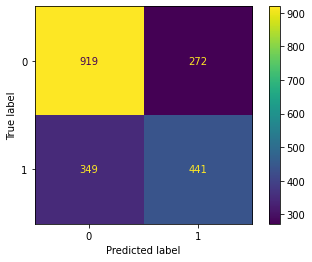

In [1047]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(X_train_sc_3, imp_training_y)

predict_lr = lr.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_lr)

In [1048]:
probs_lr = lr.predict_proba(X_test_sc_3)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(imp_testing_y, probs_lr)
auc_lr = auc(recall_lr, precision_lr)

Accuracy:  0.6875
F1:  0.6162
Recall:  0.6291
precision:  0.6039


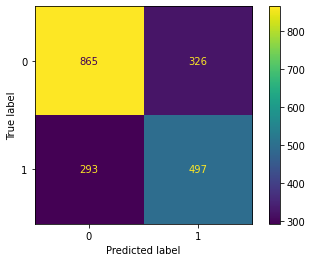

In [1049]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_sc_3,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_3)
 
evaluate(imp_testing_y,predict_xgb)

In [1050]:
probs_xgb = xgb.predict_proba(X_test_sc_3)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(imp_testing_y, probs_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)

Accuracy:  0.6835
F1:  0.6511
Recall:  0.7405
precision:  0.5809


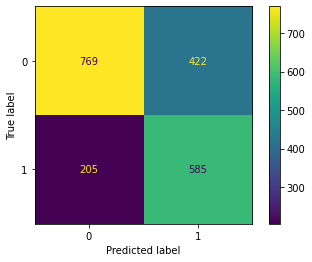

In [1051]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_gnb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

In [1052]:
probs_gnb= gnb.predict_proba(X_test_sc_3)[:, 1]
precision_gnb, recall_gnb, _ = precision_recall_curve(imp_testing_y, probs_gnb)
auc_gnb = auc(recall_gnb, precision_gnb)

Accuracy:  0.6784
F1:  0.6001
Recall:  0.6051
precision:  0.5953


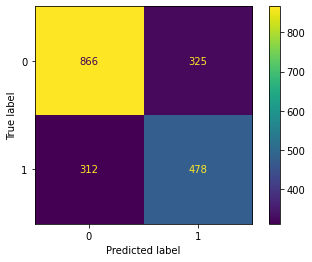

In [1053]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_3,imp_training_y)

predict_knn = knn.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_knn)

In [1054]:
probs_knn = knn.predict_proba(X_test_sc_3)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(imp_testing_y, probs_knn)
auc_knn = auc(recall_knn, precision_knn)

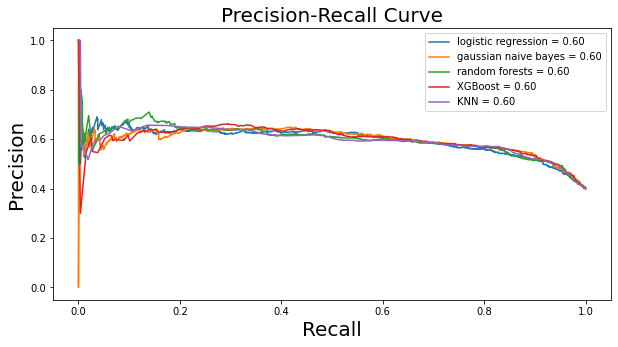

In [1055]:
plt.figure(figsize=(10, 5))
plt.plot(recall_lr, precision_lr, label=f'logistic regression = {auc_lr:.2f}')
plt.plot(recall_gnb, precision_gnb, label=f'gaussian naive bayes = {auc_gnb:.2f}')
plt.plot(recall_rf, precision_rf, label=f'random forests = {auc_rf:.2f}')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost = {auc_xgb:.2f}')
plt.plot(recall_knn, precision_knn, label=f'KNN = {auc_knn:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=20)
plt.ylabel('Precision', size=20)
plt.legend();

In [722]:
X_train_sc_3.columns

Index(['hs_gpa', 'm_facility', 'edu_confidence'], dtype='object')

All of these models used the 'X_train_sc_3' dataset.  It is scaled and only has features 'm_facility', and
'edu_confidence'.  'hs_gpa' is a an estimate of the students grade point average broken down into six categories with ordinal value. 'm_facility' is a feature I constructed by multiplying the students mathematical standasrdized testing score feature by the feature identifying highest math class completed in high schoool.  Math was identified in the exploratory analysis and feature importances as being useful in the classifcation task.  'edu_confidence' was a feature included in the original dataset and corresponds to this highest level of education the student expects to complete.  It an ordinal feature corresponding to achievments like 'phd', 'associates degree', etc... These features were identfied by the feature importances function during the random forest modelling as having the highest influence on correct classification. The 3 feature models are interesting to me because they are directly relevant to the classification task visualized by the 3d scatterplot in the final notebook.<br>

### best 3 feature models:
random forest:<br>
Accuracy:  0.6855<br>
F1:  0.6217<br>
Recall:  0.6481<br>
precision:  0.5974<br>

logistic regression:<br>
Accuracy:  0.6865<br>
F1:  0.5868<br>
Recall:  0.5582<br>
precision:  0.6185<br>

xgboost:<br>
Accuracy:  0.6875<br>
F1:  0.6162<br>
Recall:  0.6291<br>
precision:  0.6039<br>

gaussian naive bayes:<br>
Accuracy:  0.6835<br>
F1:  0.6511<br>
Recall:  0.7405<br>
precision:  0.5809<br>

knn:<br>
Accuracy:  0.6784<br>
F1:  0.6036<br>
Recall:  0.6139<br>
precision:  0.5936<br>

### best models:
best knn: <br>
X_train_sc_20 - tuned:<br>
Accuracy:  0.683<br>
F1:  0.6226<br>
Recall:  0.6557<br>
precision:  0.5927<br>

beast gaussian naive bayes:
X_train_sc_3<br>
Accuracy:  0.6835<br>
F1:  0.6511<br>
Recall:  0.7405<br>
precision:  0.5809<br>

best random forest:<br>
X_train_kb20:<br>
Accuracy:  0.687<br>
F1:  0.6149<br>
Recall:  0.6266<br>
precision:  0.6037<br>

best logistic regression:<br>
X_train_sc_15<br>
Accuracy:  0.6896<br>
F1:  0.5946<br>
Recall:  0.5709<br>
precision:  0.6204<br>

xgboost:<br>
X_train_sc_20<br>
Accuracy:  0.689<br>
F1:  0.6183<br>
Recall:  0.6316<br>
precision:  0.6056<br>

## Best Model Gaussian Niave Bayes:

Accuracy:  0.6835
F1:  0.6511
Recall:  0.7405
precision:  0.5809


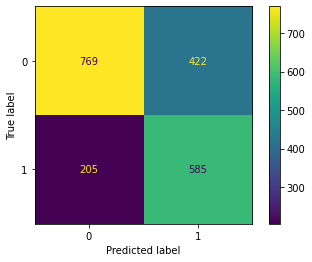

In [40]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_gnb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

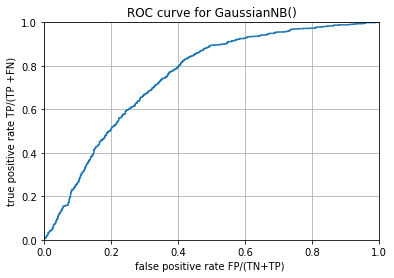

In [41]:
ROC(X_test_sc_3, gnb)